#References
+ https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
+ https://towardsdatascience.com/hands-on-time-series-forecasting-with-python-d4cdcabf8aac
+ https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
+ https://www.tensorflow.org/tutorials/structured_data/time_series?hl=en

In [1]:
import tensorflow as tf
import os
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
import matplotlib
import statsmodels.api as sm
from scipy.stats import norm
from helpers.functional import Compose

In [2]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
COLOR="#89cff0"

In [3]:
def get_weather_data():
    """ Retrieve weather data.
    From tensor flow tutorial https://www.tensorflow.org/tutorials/structured_data/time_series?hl=en
    """
    zip_path = tf.keras.utils.get_file(
        origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
        fname='jena_climate_2009_2016.csv.zip',
        cache_dir = "~/",
        cache_subdir = "resources",
        extract=True)
    csv_path, _ = os.path.splitext(zip_path)
    df = pd.read_csv(csv_path)
    df = df[5::6] # 1 hour intervals
    date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
    return df, date_time


def get_sales_data():
    """Superstore data 
    From https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls
    Used in Blog Post: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
    This blog post filters for 'furniture'
    """
    return pd.read_excel("resources/sample _superstore.xls")


In [4]:
#df, date_time = get_weather_data()

In [5]:
def filter_furniture(df: DataFrame):
    return df[df['Category'] == 'Furniture']


def univariate(df: DataFrame):
    cols = ["Order Date", "Sales"]
    return df[cols].groupby("Order Date").sum()
    

def to_month_ts(df: DataFrame):
    return df.resample("MS").mean()
    
    
def prepare_furniture_data(df: DataFrame):
    f = Compose(filter_furniture, univariate, to_month_ts)
    return f(df)
     

In [6]:
# Time series analysis

def decompose_time_series(df: DataFrame, model="additive"):
    dc = sm.tsa.seasonal_decompose(df, model=model)
    fig, ax  = plt.subplots(4, figsize=(15,8), sharex=True, sharey=True)
    ax[0].plot(dc.observed, lw=4, color=COLOR)
    ax[0].set_ylabel("Observed")
    ax[1].plot(dc.seasonal, lw=2, color="k")
    ax[1].set_ylabel("Seasonal")
    ax[2].plot(dc.trend, "-", lw=2, color="k") 
    ax[2].set_ylabel("Trend")
    ax[3].plot(dc.resid, "-", lw=2, color="k")
    ax[3].set_ylabel("Residual")
    ax[3].set_xlabel("Time")
    for i in range(4):
        ax[i].grid()
    fig.subplots_adjust(wspace=0, hspace=0)
    

def plot_ts(df: DataFrame, column: str):
    """Plots time series assuming time as index"""
    fig, ax  = plt.subplots(figsize=(15,3))
    ax.plot(df.index, df[column], lw=4, color=COLOR)
    ax.grid()
    ax.set_ylabel(column)
    ax.set_xlabel("Time")

In [7]:
df = prepare_furniture_data(get_sales_data())

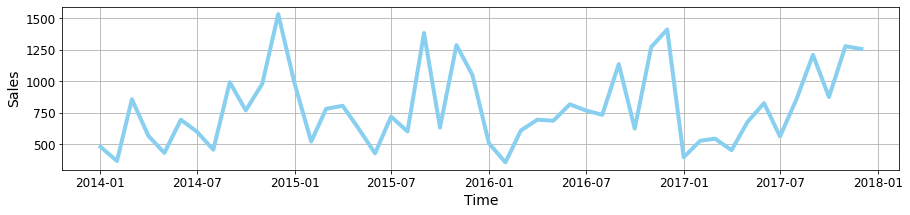

In [8]:
plot_ts(df, "Sales")

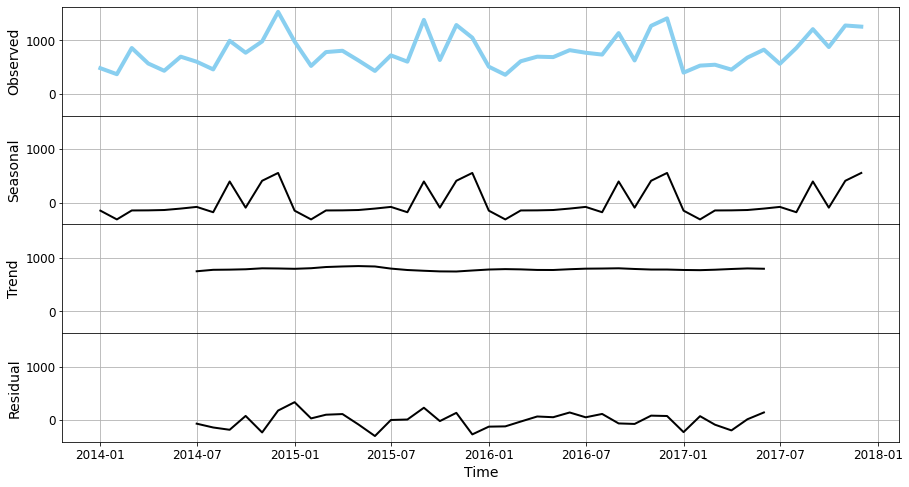

In [9]:
decompose_time_series(df)

In [10]:
mod = sm.tsa.SARIMAX(df, order=(2,0,0))
result = mod.fit()

In [11]:
result.summary()
#result.plot_diagnostics(figsize=(12,12))
#plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   48
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -348.287
Date:                Thu, 15 Oct 2020   AIC                            702.573
Time:                        19:05:00   BIC                            708.187
Sample:                    01-01-2014   HQIC                           704.695
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5677      0.138      4.105      0.000       0.297       0.839
ar.L2          0.3774      0.134      2.817      0.005       0.115       0.640
sigma2      1.125e+05   2.29e+04      4.909      0.000    6.76e+04    1.57e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.25   Prob(JB):                         0.42
Heteroskedasticity (H):               1.35   Skew:                            -0.42
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
import tensorflow_probability as tfp
import numpy as np
from pandas import Series
from scipy.stats import gaussian_kde

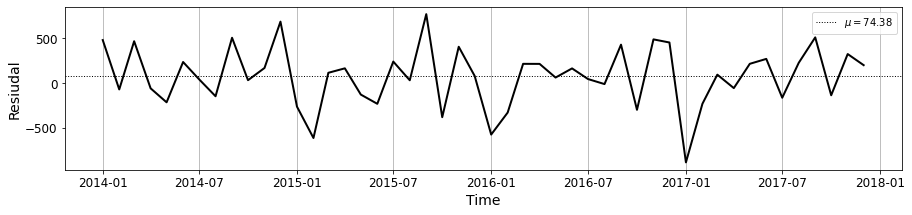

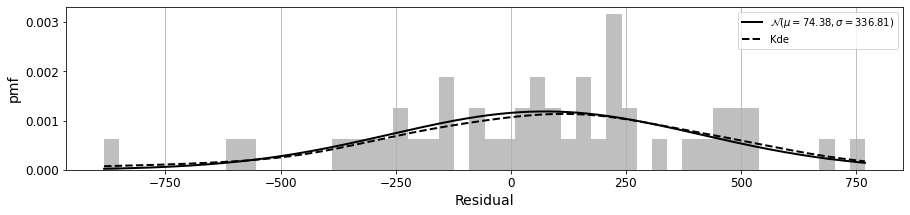

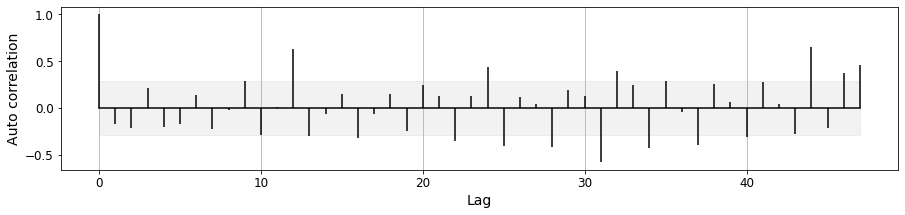

In [13]:

def auto_correlation(s: pd.Series, max_lags=None):
     return tfp.stats.auto_correlation(s, axis=0, max_lags=max_lags)

def plot_auto_correlation(acs, limits:callable):
    fig, ax = plt.subplots(figsize=(15,3))
    ax.stem(acs, markerfmt=" ", linefmt="k", basefmt="k")
    xs = tf.range(acs.shape[0])
    ys = limits(xs)
    ax.fill_between(xs, ys, -ys, color="grey", alpha=.1)
    ax.set_xlabel("Lag")
    ax.set_ylabel("Auto correlation")
    ax.grid(axis="x")
    
def plot_residuals(res: Series):
    fig, ax = plt.subplots(figsize=(15,3))
    ax.plot(res, color="k", lw=2)
    mu = np.round(res.mean(), 2)
    ax.axhline(mu, ls=":", lw=1, color="k", label=r"$\mu={mu}$".format(mu=mu))
    ax.set_xlabel("Time")
    ax.set_ylabel("Resiudal")
    ax.legend()
    ax.grid(axis="x")
    
    
def plot_resiudals_histogram(res: Series, bins=30):
    fig, ax = plt.subplots(figsize=(15,3))
    ax.hist(res, bins=50, density=True, color="black", alpha=.25, lw=2)    
    mu = res.mean()
    std = res.std()
    xs = np.arange(res.quantile(0), res.quantile(1))
    ys_norm = norm(loc=mu, scale=std).pdf(xs)
    ys_kde = gaussian_kde(res).evaluate(xs)
    label = r'$\mathcal{N}$' + r'$(\mu={mu}, \sigma={sq})$'.format(mu=np.round(mu, 2), sq=np.round(std, 2))
    ax.plot(xs, ys_norm, color="k", lw=2, label=label)
    ax.plot(xs, ys_kde, "--", color="k", lw=2, label="Kde")
    ax.set_xlabel("Residual")
    ax.set_ylabel("pmf")
    ax.legend()
    ax.grid(axis="x")
    
    
    
res = result.resid
acs = auto_correlation(res)
limits = lambda x: np.ones(x.shape[0])* 2/np.sqrt(df.shape[0])
plot_residuals(res)
plot_resiudals_histogram(res)
plot_auto_correlation(acs, limits)